In [24]:
import os
import pandas as pd
import numpy as np
import utils.runs as runs_joint
import utils.single_label as runs_sl
from utils.projects import PROJECTS
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
import wandb

In [26]:
attrs_dict = {'male': 20,
              'young': 39,
              'big_nose': 7,
              'big-nose': 7,
              'big_lips': 6,
              'big-lips': 6,
              'oval_face': 25,
              'oval-face': 25,
              'mustache': 22,
              'receding_hairline': 28,
              'receding-hairline': 28,
             }

In [27]:
joint_runs_proj = "celeba-all-rn18"
single_runs_proj = "celeba-single-rn18"
combined_runs_proj = "celeba-combined-rn18"

In [28]:
joint_runs = runs_joint.get_runs_for_project(joint_runs_proj)
single_runs = runs_sl.get_runs_for_project(single_runs_proj)
combined_runs = runs_sl.get_runs_for_project(combined_runs_proj)

dict_keys(['blond'])
dict_keys(['blond', 'smiling'])
dict_keys(['blond', 'smiling', 'oval-face'])
dict_keys(['blond', 'smiling', 'oval-face', 'big-nose'])
dict_keys(['blond', 'smiling', 'oval-face', 'big-nose', 'mustache'])
dict_keys(['blond', 'smiling', 'oval-face', 'big-nose', 'mustache', 'receding-hairline'])
dict_keys(['blond', 'smiling', 'oval-face', 'big-nose', 'mustache', 'receding-hairline', 'bags-under-eyes'])


In [31]:
def get_ba_stats(runs, protected_attr_label, attr_label, strategy='single'):
    ba_stats = []
    has_PT = False
    covs_df, pos_fracs_df, neg_fracs_df = runs_joint.compute_cooccurrence_matrices('celeba')
    for i, r in enumerate(runs):
        if not (os.path.exists(os.path.join(r['run_dir'], 'test_outputs.txt')) or os.path.exists(os.path.join(r['run_dir'], 'test_outputs_best.txt'))):
            print(os.path.exists(os.path.join(r['run_dir'], 'test_outputs.txt')),
                  os.path.join(r['run_dir'], 'test_outputs.txt'))
            print(os.path.exists(os.path.join(r['run_dir'], 'test_outputs_best.txt')), 
                  os.path.join(r['run_dir'], 'test_outputs_best.txt'))
            continue
        
        if strategy=='joint':
            r = runs_joint.load_run_details(r, pos_fracs_df, neg_fracs_df, 0)
            ba = r[f'{protected_attr_label.capitalize()}-bas'][attrs_dict[attr_label]]
        else:
            r = runs_sl.load_run_details(r, pos_fracs_df, neg_fracs_df, 0)
            ba = r[f'{protected_attr_label.capitalize()}-bas']
        run_strategy = 'RI'
        if strategy=='joint' and ('Dense' in r['strategy'] or 'PT' in r['strategy']):
            has_PT = True
            run_strategy = 'PT'
        if r['sparsity']==99.5:
            r['sparsity'] = 995
        nice_attr_name = (' ').join([w.capitalize() for w in attr_label.split('_')])
        ba_stats.append({f'{nice_attr_name} BA': ba, 'Sparsity': str(int(r['sparsity'])),
                        'Strategy': strategy + '-' + run_strategy})
        if r['strategy']=='Dense' and has_PT:
            ba_stats.append({f'{nice_attr_name} BA': ba, 'Sparsity': str(int(r['sparsity'])),
                        'Strategy': strategy + '-' + 'RI'})
    ba_stats_df = pd.DataFrame(ba_stats)
    return ba_stats_df



def plot_all_ba_stats(joint_runs, attr_single_runs, attr_combined_runs, protected_attr_label, attr_label):
    ba_stats_joint = get_ba_stats(joint_runs, protected_attr_label, attr_label, strategy='joint')
    ba_stats_single = get_ba_stats(attr_single_runs, protected_attr_label, attr_label, strategy='single')
    ba_stats_combined = get_ba_stats(attr_combined_runs, protected_attr_label, attr_label, strategy='combined')
    ba_stats = pd.concat([ba_stats_joint, ba_stats_single, ba_stats_combined], ignore_index=True)
    ba_stats = ba_stats.sort_values('Sparsity')
    print(ba_stats)
    fig, ax = plt.subplots(1,1, figsize=(10,4))
    nice_attr_name = (' ').join([w.capitalize() for w in attr_label.split('_')])
    ax.set_title(f'Bias Amplification on protected attribute {protected_attr_label.capitalize()}')
    sns.lineplot(data=ba_stats, x='Sparsity', y=f'{nice_attr_name} BA', hue='Strategy', ax=ax)
    plt.show()

In [ ]:
# import pdb
# ba_stats_joint = get_ba_stats(joint_runs, 'male', 'oval_face', strategy='joint')
# ba_stats_single = get_ba_stats(single_runs['oval-face'], 'male', 'oval_face', strategy='single')
# ba_stats_combined = get_ba_stats(combined_runs['male-oval_face'], 'male', 'oval_face', strategy='combined')

In [ ]:
# ba_stats = pd.concat([ba_stats_joint, ba_stats_single, ba_stats_combined], ignore_index=True)
# ba_stats = ba_stats.sort_values('sparsity')
# print(ba_stats)
# print(ba_stats_joint)
# print(ba_stats_single)
# print(ba_stats_combined)
# fig, ax = plt.subplots(1,1, figsize=(10,4))
# sns.lineplot(data=ba_stats, x='sparsity', y='male-oval_face-bas', hue='strategy', ax=ax)
# plt.show()

In [ ]:
# ba_stats_joint = get_ba_stats(joint_runs, 'young', 'mustache', strategy='joint')
# ba_stats_single = get_ba_stats(single_runs['mustache'], 'young', 'mustache', strategy='single')
# ba_stats_combined = get_ba_stats(combined_runs['young-mustache'], 'young', 'mustache', strategy='combined')

In [ ]:
# ba_stats = pd.concat([ba_stats_joint, ba_stats_single, ba_stats_combined], ignore_index=True)
# ba_stats = ba_stats.sort_values('sparsity')
# print(ba_stats)
# print(ba_stats_joint)
# print(ba_stats_single)
# print(ba_stats_combined)
# fig, ax = plt.subplots(1,1, figsize=(10,4))
# sns.lineplot(data=ba_stats, x='sparsity', y='young-mustache-bas', hue='strategy', ax=ax)
# plt.show()

/nfs/scistore14/alistgrp/eiofinov/iht-sparse/./experiments_celeba_rn18_bias/resnet18_gmps99_cosinelr_0505norms_valid/seed25/20221021183856
USING THE CACHE
/nfs/scistore14/alistgrp/eiofinov/iht-sparse/./experiments_celeba_rn18_bias/resnet18_gmps99_cosinelr_0505norms_valid/seed24/20221021105801
USING THE CACHE
/nfs/scistore14/alistgrp/eiofinov/iht-sparse/./experiments_celeba_rn18_bias/resnet18_gmps99_cosinelr_0505norms_valid/seed23/20221012025637
USING THE CACHE
/nfs/scistore14/alistgrp/eiofinov/iht-sparse/./experiments_celeba_rn18_bias/resnet18_gmps99_cosinelr_0505norms_valid/seed22/20221011191145
USING THE CACHE
/nfs/scistore14/alistgrp/eiofinov/iht-sparse/./experiments_celeba_rn18_bias/resnet18_gmps99_cosinelr_0505norms_valid/seed21/20221011113315
USING THE CACHE
/nfs/scistore14/alistgrp/eiofinov/iht-sparse/./experiments_celeba_rn18_bias/resnet18_gmps95_cosinelr_0505norms_valid/seed25/20221020220847
USING THE CACHE
/nfs/scistore14/alistgrp/eiofinov/iht-sparse/./experiments_celeba_rn18

USING THE CACHE
/nfs/scistore14/alistgrp/eiofinov/iht-sparse/./experiments_bias/postgmps80__adam_ep80_batch256_lr0001_0505norms_valid/seed22/20221013215332
USING THE CACHE
/nfs/scistore14/alistgrp/eiofinov/iht-sparse/./experiments_bias/postgmps80__adam_ep80_batch256_lr0001_0505norms_valid/seed21/20221013153737
USING THE CACHE
/nfs/scistore14/alistgrp/eiofinov/iht-sparse/./experiments_bias/postgmps90__adam_ep80_batch256_lr0001_0505norms_valid/seed25/20221014164116
USING THE CACHE
/nfs/scistore14/alistgrp/eiofinov/iht-sparse/./experiments_bias/postgmps90__adam_ep80_batch256_lr0001_0505norms_valid/seed24/20221014102145
USING THE CACHE
/nfs/scistore14/alistgrp/eiofinov/iht-sparse/./experiments_bias/postgmps90__adam_ep80_batch256_lr0001_0505norms_valid/seed23/20221014040601
USING THE CACHE
/nfs/scistore14/alistgrp/eiofinov/iht-sparse/./experiments_bias/postgmps90__adam_ep80_batch256_lr0001_0505norms_valid/seed22/20221013215202
USING THE CACHE
/nfs/scistore14/alistgrp/eiofinov/iht-sparse/./e

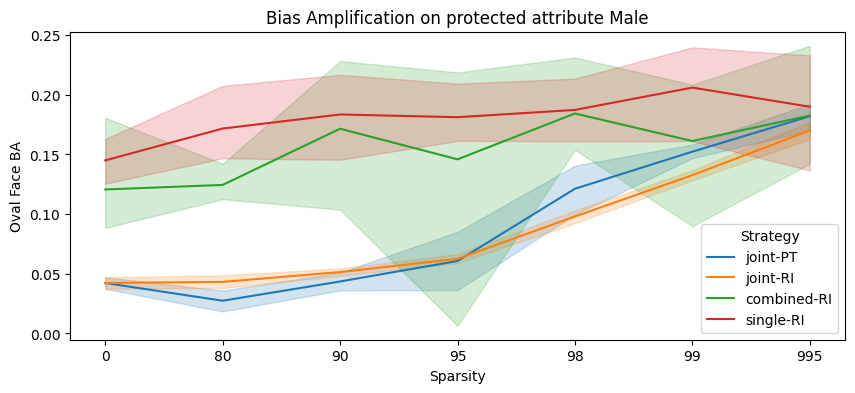

In [32]:
plot_all_ba_stats(joint_runs, single_runs['oval-face'], combined_runs['male-oval_face'], 'male', 'oval_face')

/nfs/scistore14/alistgrp/eiofinov/iht-sparse/./experiments_celeba_rn18_bias/resnet18_gmps99_cosinelr_0505norms_valid/seed25/20221021183856
USING THE CACHE
/nfs/scistore14/alistgrp/eiofinov/iht-sparse/./experiments_celeba_rn18_bias/resnet18_gmps99_cosinelr_0505norms_valid/seed24/20221021105801
USING THE CACHE
/nfs/scistore14/alistgrp/eiofinov/iht-sparse/./experiments_celeba_rn18_bias/resnet18_gmps99_cosinelr_0505norms_valid/seed23/20221012025637
USING THE CACHE
/nfs/scistore14/alistgrp/eiofinov/iht-sparse/./experiments_celeba_rn18_bias/resnet18_gmps99_cosinelr_0505norms_valid/seed22/20221011191145
USING THE CACHE
/nfs/scistore14/alistgrp/eiofinov/iht-sparse/./experiments_celeba_rn18_bias/resnet18_gmps99_cosinelr_0505norms_valid/seed21/20221011113315
USING THE CACHE
/nfs/scistore14/alistgrp/eiofinov/iht-sparse/./experiments_celeba_rn18_bias/resnet18_gmps95_cosinelr_0505norms_valid/seed25/20221020220847
USING THE CACHE
/nfs/scistore14/alistgrp/eiofinov/iht-sparse/./experiments_celeba_rn18

USING THE CACHE
/nfs/scistore14/alistgrp/eiofinov/iht-sparse/./experiments_bias/postgmps80__adam_ep80_batch256_lr0001_0505norms_valid/seed22/20221013215332
USING THE CACHE
/nfs/scistore14/alistgrp/eiofinov/iht-sparse/./experiments_bias/postgmps80__adam_ep80_batch256_lr0001_0505norms_valid/seed21/20221013153737
USING THE CACHE
/nfs/scistore14/alistgrp/eiofinov/iht-sparse/./experiments_bias/postgmps90__adam_ep80_batch256_lr0001_0505norms_valid/seed25/20221014164116
USING THE CACHE
/nfs/scistore14/alistgrp/eiofinov/iht-sparse/./experiments_bias/postgmps90__adam_ep80_batch256_lr0001_0505norms_valid/seed24/20221014102145
USING THE CACHE
/nfs/scistore14/alistgrp/eiofinov/iht-sparse/./experiments_bias/postgmps90__adam_ep80_batch256_lr0001_0505norms_valid/seed23/20221014040601
USING THE CACHE
/nfs/scistore14/alistgrp/eiofinov/iht-sparse/./experiments_bias/postgmps90__adam_ep80_batch256_lr0001_0505norms_valid/seed22/20221013215202
USING THE CACHE
/nfs/scistore14/alistgrp/eiofinov/iht-sparse/./e

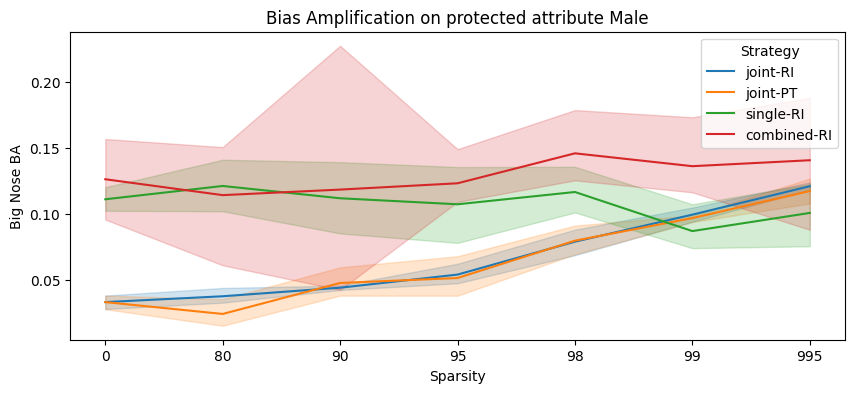

In [33]:
plot_all_ba_stats(joint_runs, single_runs['big-nose'], combined_runs['male-big_nose'], 'male', 'big_nose')

/nfs/scistore14/alistgrp/eiofinov/iht-sparse/./experiments_celeba_rn18_bias/resnet18_gmps99_cosinelr_0505norms_valid/seed25/20221021183856
USING THE CACHE
/nfs/scistore14/alistgrp/eiofinov/iht-sparse/./experiments_celeba_rn18_bias/resnet18_gmps99_cosinelr_0505norms_valid/seed24/20221021105801
USING THE CACHE
/nfs/scistore14/alistgrp/eiofinov/iht-sparse/./experiments_celeba_rn18_bias/resnet18_gmps99_cosinelr_0505norms_valid/seed23/20221012025637
USING THE CACHE
/nfs/scistore14/alistgrp/eiofinov/iht-sparse/./experiments_celeba_rn18_bias/resnet18_gmps99_cosinelr_0505norms_valid/seed22/20221011191145
USING THE CACHE
/nfs/scistore14/alistgrp/eiofinov/iht-sparse/./experiments_celeba_rn18_bias/resnet18_gmps99_cosinelr_0505norms_valid/seed21/20221011113315
USING THE CACHE
/nfs/scistore14/alistgrp/eiofinov/iht-sparse/./experiments_celeba_rn18_bias/resnet18_gmps95_cosinelr_0505norms_valid/seed25/20221020220847
USING THE CACHE
/nfs/scistore14/alistgrp/eiofinov/iht-sparse/./experiments_celeba_rn18

USING THE CACHE
/nfs/scistore14/alistgrp/eiofinov/iht-sparse/./experiments_bias/postgmps80__adam_ep80_batch256_lr0001_0505norms_valid/seed22/20221013215332
USING THE CACHE
/nfs/scistore14/alistgrp/eiofinov/iht-sparse/./experiments_bias/postgmps80__adam_ep80_batch256_lr0001_0505norms_valid/seed21/20221013153737
USING THE CACHE
/nfs/scistore14/alistgrp/eiofinov/iht-sparse/./experiments_bias/postgmps90__adam_ep80_batch256_lr0001_0505norms_valid/seed25/20221014164116
USING THE CACHE
/nfs/scistore14/alistgrp/eiofinov/iht-sparse/./experiments_bias/postgmps90__adam_ep80_batch256_lr0001_0505norms_valid/seed24/20221014102145
USING THE CACHE
/nfs/scistore14/alistgrp/eiofinov/iht-sparse/./experiments_bias/postgmps90__adam_ep80_batch256_lr0001_0505norms_valid/seed23/20221014040601
USING THE CACHE
/nfs/scistore14/alistgrp/eiofinov/iht-sparse/./experiments_bias/postgmps90__adam_ep80_batch256_lr0001_0505norms_valid/seed22/20221013215202
USING THE CACHE
/nfs/scistore14/alistgrp/eiofinov/iht-sparse/./e

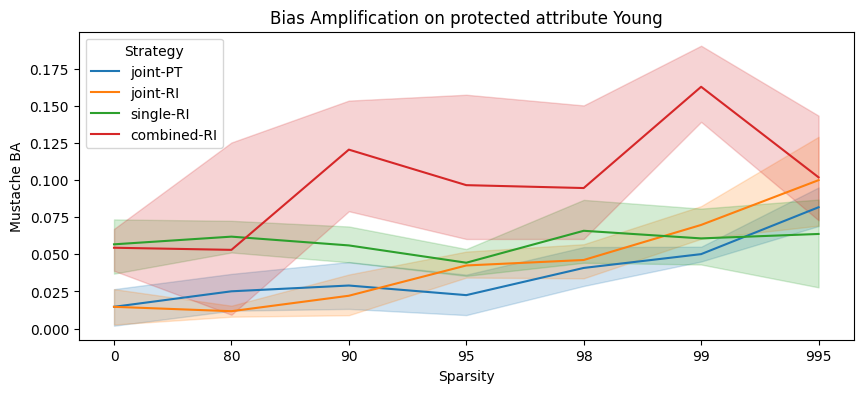

In [34]:
plot_all_ba_stats(joint_runs, single_runs['mustache'], combined_runs['young-mustache'], 'young', 'mustache')

/nfs/scistore14/alistgrp/eiofinov/iht-sparse/./experiments_celeba_rn18_bias/resnet18_gmps99_cosinelr_0505norms_valid/seed25/20221021183856
USING THE CACHE
/nfs/scistore14/alistgrp/eiofinov/iht-sparse/./experiments_celeba_rn18_bias/resnet18_gmps99_cosinelr_0505norms_valid/seed24/20221021105801
USING THE CACHE
/nfs/scistore14/alistgrp/eiofinov/iht-sparse/./experiments_celeba_rn18_bias/resnet18_gmps99_cosinelr_0505norms_valid/seed23/20221012025637
USING THE CACHE
/nfs/scistore14/alistgrp/eiofinov/iht-sparse/./experiments_celeba_rn18_bias/resnet18_gmps99_cosinelr_0505norms_valid/seed22/20221011191145
USING THE CACHE
/nfs/scistore14/alistgrp/eiofinov/iht-sparse/./experiments_celeba_rn18_bias/resnet18_gmps99_cosinelr_0505norms_valid/seed21/20221011113315
USING THE CACHE
/nfs/scistore14/alistgrp/eiofinov/iht-sparse/./experiments_celeba_rn18_bias/resnet18_gmps95_cosinelr_0505norms_valid/seed25/20221020220847
USING THE CACHE
/nfs/scistore14/alistgrp/eiofinov/iht-sparse/./experiments_celeba_rn18

USING THE CACHE
/nfs/scistore14/alistgrp/eiofinov/iht-sparse/./experiments_bias/postgmps80__adam_ep80_batch256_lr0001_0505norms_valid/seed22/20221013215332
USING THE CACHE
/nfs/scistore14/alistgrp/eiofinov/iht-sparse/./experiments_bias/postgmps80__adam_ep80_batch256_lr0001_0505norms_valid/seed21/20221013153737
USING THE CACHE
/nfs/scistore14/alistgrp/eiofinov/iht-sparse/./experiments_bias/postgmps90__adam_ep80_batch256_lr0001_0505norms_valid/seed25/20221014164116
USING THE CACHE
/nfs/scistore14/alistgrp/eiofinov/iht-sparse/./experiments_bias/postgmps90__adam_ep80_batch256_lr0001_0505norms_valid/seed24/20221014102145
USING THE CACHE
/nfs/scistore14/alistgrp/eiofinov/iht-sparse/./experiments_bias/postgmps90__adam_ep80_batch256_lr0001_0505norms_valid/seed23/20221014040601
USING THE CACHE
/nfs/scistore14/alistgrp/eiofinov/iht-sparse/./experiments_bias/postgmps90__adam_ep80_batch256_lr0001_0505norms_valid/seed22/20221013215202
USING THE CACHE
/nfs/scistore14/alistgrp/eiofinov/iht-sparse/./e

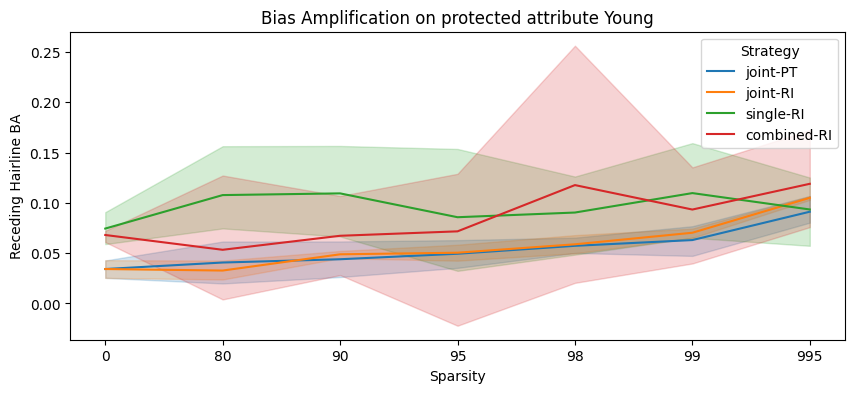

In [35]:
plot_all_ba_stats(joint_runs, single_runs['receding-hairline'], combined_runs['young-receding_hairline'], 'young', 'receding_hairline')